In [116]:
%config InlineBackend.figure_formats = {"retina", "png"}

import os
import tempfile

os.environ["OPENBLAS_NUM_THREADS"] = "1"

from IPython.display import HTML, display
import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.sparse as sp

plt.rcParams["figure.figsize"] = (5, 4)

import tdgl
from tdgl.geometry import box, circle
from tdgl.visualization.animate import create_animation
from tdgl import TDGLSolver,SolverResult
from tdgl.geometry import box
from tdgl.solver.runner import DataHandler, Runner
from tdgl.solution.solution import Solution
from tdgl.solver.options import SparseSolver
import itertools
import logging
logger = logging.getLogger("solver")
from datetime import datetime

from scipy.signal import find_peaks
#plt.rcParams['animation.ffmpeg_path'] = "C:\\FFmpeg\\bin\\ffmpeg"

np.set_printoptions(linewidth=100)

In [117]:
MAKE_ANIMATIONS = True
tempdir = tempfile.TemporaryDirectory()
tempdir

<TemporaryDirectory '/var/folders/t7/4qq067ln4xzfz0kchzzzlhkw0000gn/T/tmpvc9fuunl'>

In [118]:
def make_video_from_solution(
    solution,
    quantities=("order_parameter", "phase"),
    fps=20,
    figsize=(5, 4),
):
    """Generates an HTML5 video from a tdgl.Solution."""
    with tdgl.non_gui_backend():
        with h5py.File(solution.path, "r") as h5file:
            anim = create_animation(
                h5file,
                quantities=quantities,
                fps=fps,
                figure_kwargs=dict(figsize=figsize),
            )
            video = anim.to_html5_video()
        return HTML(video)

In [119]:
class TDGLSolverFluc(TDGLSolver):
    def __init__(self, device, options, applied_vector_potential = 0.0, terminal_currents =  None, disorder_epsilon = 1.0, seed_solution = None, T = 0):
        super().__init__(device, options, applied_vector_potential, terminal_currents,disorder_epsilon, seed_solution)
        self.T = T
    
    def therm_fluc(self):
        T= self.T
        therm =  np.zeros([len(self.sites),]) 
        if T==0:
            return therm
        sd = np.sqrt(4*5.79*np.sqrt(2)*10**(-4)*T/(1-T))

        therm =  np.array(np.random.normal(loc=0,scale=sd,size=[len(self.sites),]),dtype = 'complex')+\
                1j*np.array(np.random.normal(loc=0,scale=sd,size=[len(self.sites),]),dtype = 'complex')
        
        for t in self.terminal_info:
            therm[t.site_indices]=0
        return therm
    @staticmethod
    def solve_for_psi_squared(
        *,
        psi: np.ndarray,
        abs_sq_psi: np.ndarray,
        mu: np.ndarray,
        epsilon: np.ndarray,
        gamma: float,
        u: float,
        dt: float,
        T:float,
        therm:np.ndarray,
        psi_laplacian: sp.spmatrix,
    ):
        if isinstance(psi, np.ndarray):
            xp = np
        else:
            assert cupy is not None
            assert isinstance(psi, cupy.ndarray)
            xp = cupy
        U = xp.exp(-1j * mu * dt)
        z = U * gamma**2 / 2 * psi
        with np.errstate(all="raise"):
            try:
                w = z * abs_sq_psi + U * (
                    psi
                    + (dt / u)
                    * xp.sqrt(1 + gamma**2 * abs_sq_psi)
                    * ((epsilon - abs_sq_psi) * psi* (1-T)+therm + psi_laplacian @ psi)#modification
                )
                c = w.real * z.real + w.imag * z.imag
                two_c_1 = 2 * c + 1
                w2 = xp.absolute(w) ** 2
                discriminant = two_c_1**2 - 4 * xp.absolute(z) ** 2 * w2
            except Exception:
                logger.warning("Unable to solve for |psi|^2.", exc_info=True)
                return None
        if xp.any(discriminant < 0):
            return None
        new_sq_psi = (2 * w2) / (two_c_1 + xp.sqrt(discriminant))
        psi = w - z * new_sq_psi
        return psi, new_sq_psi

    def adaptive_euler_step(
        self,
        step: int,
        psi: np.ndarray,
        abs_sq_psi: np.ndarray,
        mu: np.ndarray,
        epsilon: np.ndarray,
        therm:np.ndarray,
        dt: float,
    ):
        options = self.options
        kwargs = dict(
            psi=psi,
            abs_sq_psi=abs_sq_psi,
            mu=mu,
            epsilon=epsilon,
            T=self.T,
            therm=therm,
            gamma=self.gamma,
            u=self.u,
            dt=dt,
            psi_laplacian=self.operators.psi_laplacian,
        )
        result = self.solve_for_psi_squared(**kwargs)
        for retries in itertools.count():
            if result is not None:
                break  # First evaluation of |psi|^2 was successful.
            if not options.adaptive or retries > options.max_solve_retries:
                raise RuntimeError(
                    f"Solver failed to converge in {options.max_solve_retries}"
                    f" retries at step {step} with dt = {dt:.2e}."
                    f" Try using a smaller dt_init."
                )
            kwargs["dt"] = dt = dt * options.adaptive_time_step_multiplier
            result = self.solve_for_psi_squared(**kwargs)
        psi, new_sq_psi = result
        return psi, new_sq_psi, dt

    def update(
        self,state,running_state,dt,*,psi,mu,supercurrent,normal_current,
        induced_vector_potential,applied_vector_potential = None,epsilon= None):
        xp = self.xp
        options = self.options
        operators = self.operators

        
        step = state["step"]
        time = state["time"]
        A_induced = induced_vector_potential
        prev_A_applied = A_applied = applied_vector_potential

        # Update the scalar potential boundary conditions.
        self.update_mu_boundary(time)

        # Update the applied vector potential.
        dA_dt = 0.0
        current_A_applied = self.current_A_applied
        if self.dynamic_vector_potential:
            current_A_applied = self.update_applied_vector_potential(time)
            dA_dt = xp.einsum(
                "ij, ij -> i",
                (current_A_applied - prev_A_applied) / dt,
                self.normalized_directions,
            )
            if xp.any(xp.absolute(dA_dt) > 0):
                # Update the link exponents only if the applied vector potential
                # has actually changed.
                operators.set_link_exponents(current_A_applied)
        else:
            assert A_applied is None
            prev_A_applied = A_applied = current_A_applied

        

        self.current_A_applied = current_A_applied

        # Update the value of epsilon
        epsilon = self.epsilon
        if self.dynamic_epsilon:
            epsilon = self.epsilon = self.update_epsilon(time)

        old_sq_psi = xp.absolute(psi) ** 2
        screening_error = np.inf
        A_induced_vals = [A_induced]
        velocity = [0.0]  # Velocity for Polyak's method
        # This loop runs only once if options.include_screening is False
        for screening_iteration in itertools.count():
            if screening_error < options.screening_tolerance:
                break
            if screening_iteration > options.max_iterations_per_step:
                raise RuntimeError(
                    f"Screening calculation failed to converge at step {step} after"
                    f" {options.max_iterations_per_step} iterations. Relative error in"
                    f" induced vector potential: {screening_error:.2e}"
                    f" (tolerance: {options.screening_tolerance:.2e})."
                )

            # Adjust the time step and calculate the new the order parameter
            if screening_iteration == 0:
                # Find a new time step only for the first screening iteration.
                dt = self.tentative_dt

            if options.include_screening:
                # Update the link variables in the covariant Laplacian and gradient
                # for psi based on the induced vector potential from the previous iteration.
                operators.set_link_exponents(current_A_applied + A_induced)

            # Update the order parameter using an adaptive time step
                
            therm = self.therm_fluc()
            psi, abs_sq_psi, dt = self.adaptive_euler_step(
                step, psi, old_sq_psi, mu, epsilon,therm, dt
            )
            # Update the scalar potential, supercurrent density, and normal current density
            mu, supercurrent, normal_current = self.solve_for_observables(psi, dA_dt)

            if options.include_screening:
                # Evaluate the induced vector potential
                A_induced, screening_error = self.get_induced_vector_potential(
                    supercurrent + normal_current, A_induced_vals, velocity
                )
            else:
                break
        
        running_state.append("dt", dt)
        if self.probe_points is not None:
            # Update the voltage and phase difference
            running_state.append("mu", mu[self.probe_points])
            running_state.append("theta", xp.angle(psi[self.probe_points]))
        if options.include_screening:
            running_state.append("screening_iterations", screening_iteration)

        if options.adaptive:
            # Compute the max abs change in |psi|^2, averaged over the adaptive window,
            # and use it to select a new time step.
            self.d_psi_sq_vals.append(float(xp.absolute(abs_sq_psi - old_sq_psi).max()))
            window = options.adaptive_window
            if step > window:
                new_dt = options.dt_init / max(
                    1e-10, np.mean(self.d_psi_sq_vals[-window:])
                )
                self.tentative_dt = np.clip(0.5 * (new_dt + dt), 0, self.dt_max)

        results = [dt, psi, mu, supercurrent, normal_current, A_induced]
        if self.dynamic_vector_potential:
            results.append(current_A_applied)
        if self.dynamic_epsilon:
            results.append(epsilon)
        return SolverResult(*results)

    def solve_for_observables(self, psi, dA_dt) :
        use_cupy = self.use_cupy
        options = self.options
        use_cupy_solver = options.sparse_solver is SparseSolver.CUPY
        operators = self.operators
        # Compute the supercurrent, scalar potential, and normal current
        supercurrent = (1-self.T)*operators.get_supercurrent(psi)
        rhs = (operators.divergence @ (supercurrent - dA_dt)) - (
            operators.mu_boundary_laplacian @ self.mu_boundary
        )
        if use_cupy and not use_cupy_solver:
            rhs = cupy.asnumpy(rhs)
        if self.options.sparse_solver is SparseSolver.PARDISO:
            mu = pypardiso.spsolve(operators.mu_laplacian, rhs)
        else:
            mu = operators.mu_laplacian_lu(rhs)
        if use_cupy and not use_cupy_solver:
            mu = cupy.asarray(mu)
        normal_current = -(operators.mu_gradient @ mu) - dA_dt
        return mu, supercurrent, normal_current

    def solve(self):
        start_time = datetime.now()
        options = self.options
        options.validate()
        output_file = options.output_file
        seed_solution = self.seed_solution
        num_edges = self.num_edges
        probe_points = self.probe_points

        # Set the initial conditions.
        if self.seed_solution is None:
            parameters = {
                "psi": self.psi_init,
                "mu": self.mu_init,
                "supercurrent": np.zeros(num_edges),
                "normal_current": np.zeros(num_edges),
                "induced_vector_potential": np.zeros((num_edges, 2)),
            }
        else:
            if self.seed_solution.device != self.device:
                raise ValueError(
                    "The seed_solution.device must be equal to the device being simulated."
                )
            seed_data = seed_solution.tdgl_data
            parameters = {
                "psi": seed_data.psi,
                "mu": seed_data.mu,
                # "T": self.T,#modification
                "supercurrent": seed_data.supercurrent,
                "normal_current": seed_data.normal_current,
                "induced_vector_potential": seed_data.induced_vector_potential,
            }

        fixed_values = []
        fixed_names = []
        if self.dynamic_vector_potential:
            parameters["applied_vector_potential"] = self.current_A_applied
        else:
            fixed_values.append(self.current_A_applied)
            fixed_names.append("applied_vector_potential")
        if self.dynamic_epsilon:
            parameters["epsilon"] = self.epsilon
        else:
            fixed_values.append(self.epsilon)
            fixed_names.append("epsilon")

        if self.use_cupy:
            # Move arrays to the GPU
            for key, val in parameters.items():
                parameters[key] = cupy.asarray(val)
            fixed_values = tuple(cupy.asarray(val) for val in fixed_values)

        running_names_and_sizes = {"dt": 1}
        if probe_points is not None:
            running_names_and_sizes["mu"] = len(probe_points)
            running_names_and_sizes["theta"] = len(probe_points)
        if options.include_screening:
            running_names_and_sizes["screening_iterations"] = 1

        with DataHandler(output_file=output_file, logger=logger) as data_handler:
            data_handler.save_mesh(self.device.mesh)
            if data_handler.tmp_file is not None:
                self.device.to_hdf5(
                    data_handler.tmp_file.create_group("solution/device")
                )
            logger.info(
                f"Simulation started at {start_time}"
                f" using sparse solver {options.sparse_solver.value!r}"
                f" and backend {('CuPy' if self.use_cupy else 'NumPy')!r}."
            )
            runner = Runner(
                function=self.update,
                options=options,
                data_handler=data_handler,
                monitor=options.monitor,
                monitor_update_interval=options.monitor_update_interval,
                initial_values=list(parameters.values()),
                names=list(parameters),
                fixed_values=tuple(fixed_values),
                fixed_names=tuple(fixed_names),
                running_names_and_sizes=running_names_and_sizes,
                logger=logger,
            )
            data_was_generated = runner.run()
            end_time = datetime.now()
            logger.info(f"Simulation ended at {end_time}")
            logger.info(f"Simulation took {end_time - start_time}")

            solution = None
            if data_was_generated:
                solution = Solution(
                    device=self.device,
                    path=data_handler.output_path,
                    options=options,
                    applied_vector_potential=self.applied_vector_potential,
                    terminal_currents=self.terminal_currents,
                    disorder_epsilon=self.disorder_epsilon,
                    total_seconds=(end_time - start_time).total_seconds(),
                )
                solution.to_hdf5()
            return solution

In [120]:
def solveFluc(device, options,applied_vector_potential = 0,terminal_currents= None,
    disorder_epsilon = 1,seed_solution = None,T=0):
    solver = TDGLSolverFluc(
        device=device,
        options=options,
        applied_vector_potential=applied_vector_potential,
        terminal_currents=terminal_currents,
        disorder_epsilon=disorder_epsilon,
        T=T,
        seed_solution=seed_solution
    )
    return solver.solve()

# KTO Weak Link on the left

## Define Device

In [137]:
length_units = "um"
# Material parameters
xi = 0.02
london_lambda = 2.5
d = 0.005
# Device geometry
total_width = 0.4
total_length = 1.2
# link_width = total_width / 2
# Outer geometry of the film
right_notch = (
    tdgl.Polygon(points=box(total_width,10.3*xi))
    .rotate(0)
    .translate(dx=2.5 * xi)
)
left_notch = (
    tdgl.Polygon(points=box(total_width,10.3*xi))
    .rotate(0)
    .translate(dx=-total_width)
)
# right_notch = left_notch.scale(xfact=-1)
film = (
    tdgl.Polygon("film", points=box(total_width, total_length))
    .difference(right_notch)
    .difference(left_notch)
    .resample(401)#resample vertices so that they are approximately uniformly distributed along the polygon boundary
    .buffer(0)
)


# default source
# source = (
#     tdgl.Polygon("source", points=box(.7 * total_width, total_length / 100))
#     .translate(dy=total_length / 2)
# )

#left side source
# source = (
#     tdgl.Polygon("source", points=box(0.2, total_length / 100))
#     .rotate(90)
#     .translate(dy = total_length * 0.4, dx = -total_width/2)
# )

#right side source
source = (
    tdgl.Polygon("source", points=box(0.2, total_length / 100))
    .rotate(90)
    .translate(dy = total_length * 0.4, dx = total_width/2)
)


drain = source.scale(yfact=-1).set_name("drain")
#  Voltage measurement points
probe_points = [(0, total_length/2-3*xi), (0, -total_length/2+3*xi)
                # ,(total_width/2-xi, total_length/2-3*xi), (total_width/2-xi, -total_length/2+3*xi)
                ]

In [ ]:
layer1 = tdgl.Layer(coherence_length=xi, london_lambda=london_lambda, thickness=d, gamma=0.0, u=5.79, conductivity=0.3)
device1 = tdgl.Device(
    "rectangle1",
    layer=layer1,
    film=film,
    #holes=[round_hole, square_hole],
    terminals=[source, drain],
    probe_points=probe_points,
    length_units=length_units,
)

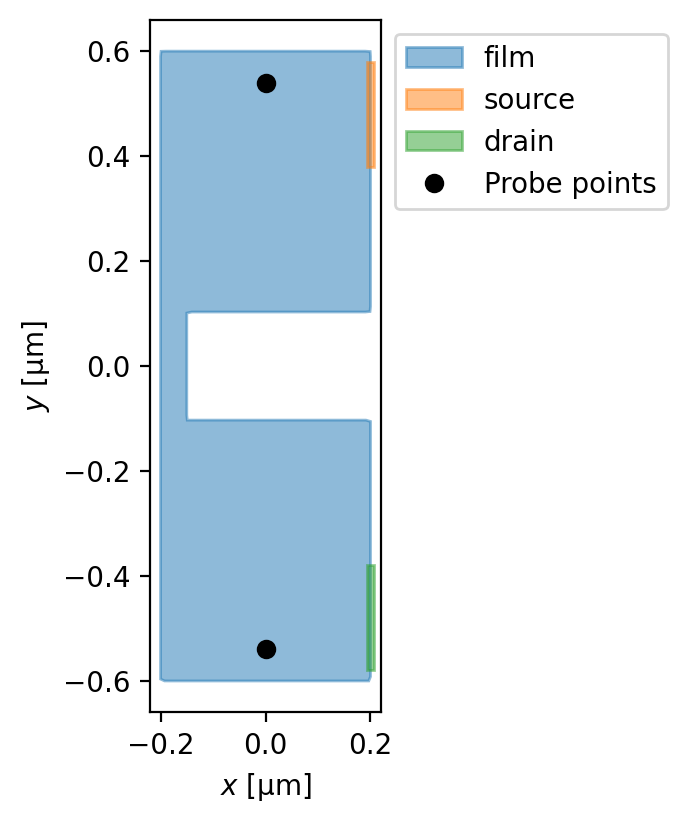

In [284]:
fig, ax = device1.draw()

In [140]:
device1.make_mesh(max_edge_length=0.77*xi , smooth=100)

Constructing Voronoi polygons: 100%|██████████| 6039/6039 [00:00<00:00, 25060.73it/s]


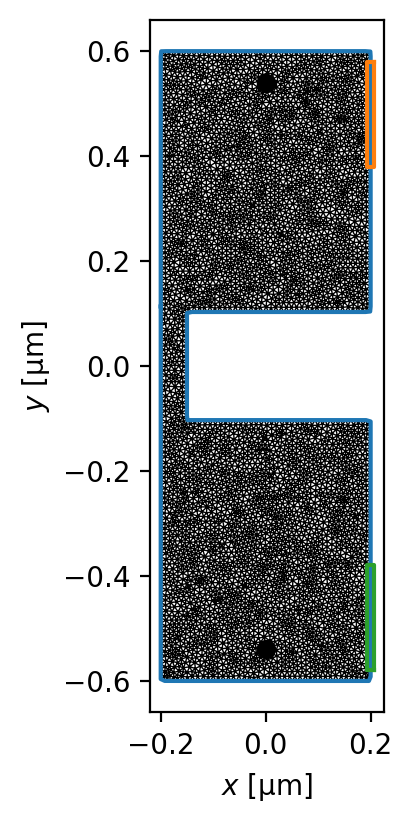

In [141]:
fig, ax = device1.plot(mesh=True, legend=False)
#_ = ax.set_ylim(-7, 7)

In [142]:
device1.mesh_stats()

## Solve for one current value

### Define Disorder

In [143]:
def dis(loc):
    # x,y=loc
    # if y < 5 * xi and y > -5 * xi:
    #     return .9
    return 1

In [144]:
options = tdgl.SolverOptions(
    skip_time = 550,
    solve_time = 650,
    output_file = os.path.join(tempdir.name, "weak-link-zero-field.h5"),
    field_units = "mT",
    current_units = "uA",
    save_every = 100
)

solution1 = solveFluc(
    device1,
    options,
    terminal_currents=dict(source = .149, drain = -.149),
    applied_vector_potential = 200,
    disorder_epsilon = 1,
    T = 0.05
)

Simulating: 100%|█████████▉| 650/650 [03:11<00:00,  3.39tau/s ]


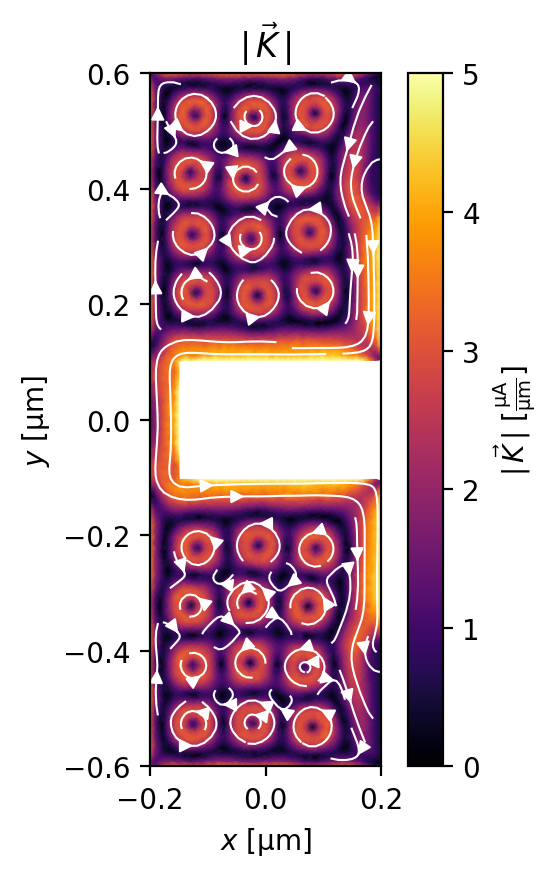

In [176]:
t0 = 100
solution1.solve_step = solution1.closest_solve_step(t0)
fig1, ax1 = solution1.plot_currents(min_stream_amp = 0.05, vmin = 0, vmax = 5, figsize = (3.5, 4.5))
fig1.savefig('K150nA_rightsource.pdf')

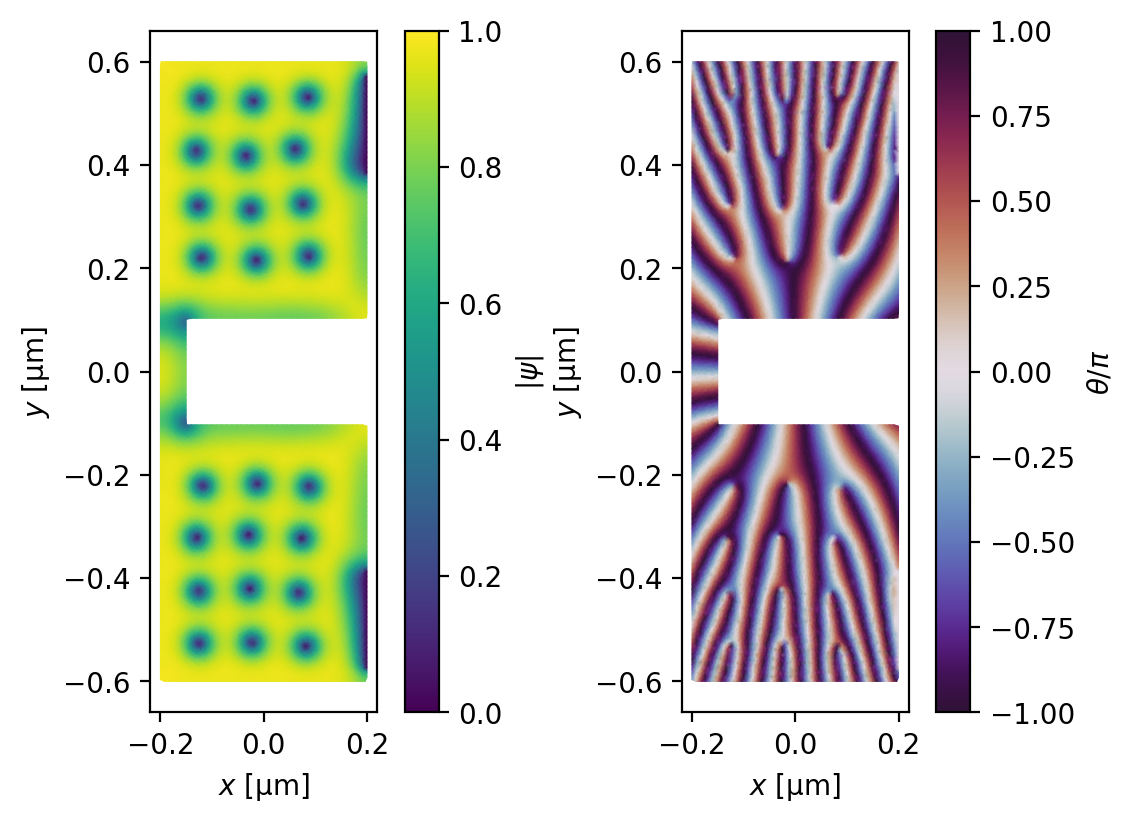

In [177]:
t0 = 100
solution1.solve_step = solution1.closest_solve_step(t0)
fig, axes = solution1.plot_order_parameter(figsize = (5.5, 4))

Text(0, 0.5, '$\\Delta \\phi/ \\pi$')

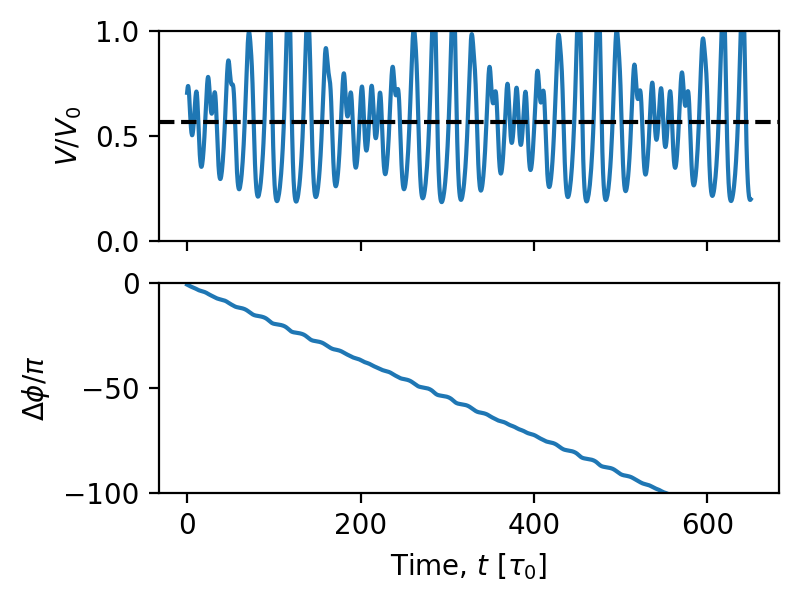

In [147]:
dynamics = solution1.dynamics
fig, axes = dynamics.plot(mean_voltage=True, tmax = 800, grid = False)


fig.set_size_inches((4, 3))
axes[0].set_ylim([-0, 1])
axes[1].set_ylim([-100, 0])
axes[0].set_ylabel('$V/V_0$')
axes[1].set_ylabel('$\Delta \phi/ \pi$')

In [148]:
dynamics.voltage().mean()

0.5943406528633487

In [149]:
if MAKE_ANIMATIONS:
    video1 = make_video_from_solution(
        solution1,
        quantities=['order_parameter', 'phase', 'scalar_potential'],
        figsize=(6.5, 4)
    )
    display(video1)

## change source and drain location

In [157]:
source = (
    tdgl.Polygon("source", points=box(0.2, total_length / 100))
    .rotate(90)
    .translate(dy = total_length * 0.4, dx = -total_width/2)
)
drain = source.scale(yfact=-1).set_name("drain")

In [158]:
layer1 = tdgl.Layer(coherence_length=xi, london_lambda=london_lambda, thickness=d, gamma=0.0, u=5.79, conductivity=0.3)
device2 = tdgl.Device(
    "rectangle1",
    layer=layer1,
    film=film,
    #holes=[round_hole, square_hole],
    terminals=[source, drain],
    probe_points=probe_points,
    length_units=length_units,
)

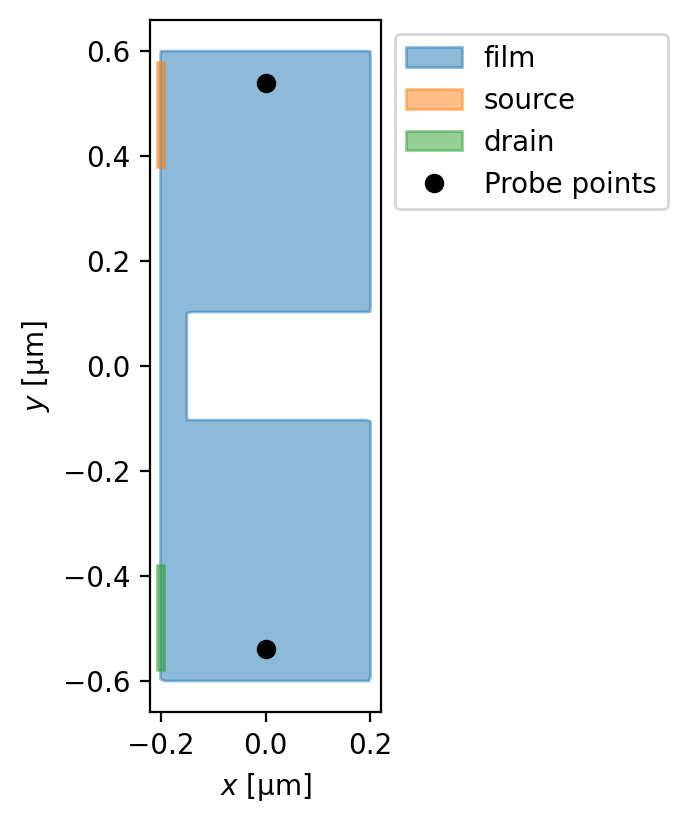

In [283]:
fig, ax = device2.draw()

In [164]:
device2.make_mesh(max_edge_length=0.77*xi , smooth=100)

Constructing Voronoi polygons: 100%|██████████| 6039/6039 [00:00<00:00, 25150.36it/s]


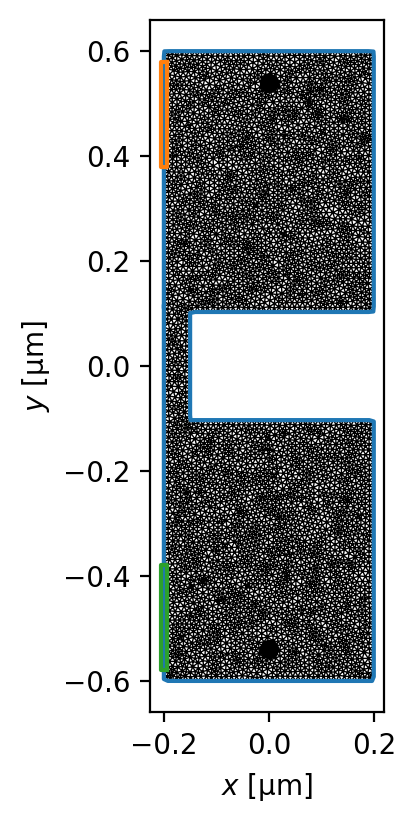

In [166]:
fig, ax = device2.plot(mesh=True, legend=False)
#_ = ax.set_ylim(-7, 7)

In [167]:
device2.mesh_stats()

In [168]:
options = tdgl.SolverOptions(
    skip_time = 550,
    solve_time = 650,
    output_file = os.path.join(tempdir.name, "weak-link-500oe-field.h5"),
    field_units = "mT",
    current_units = "uA",
    save_every = 100
)

solution2 = solveFluc(
    device2,
    options,
    terminal_currents=dict(source = .149, drain = -.149),
    applied_vector_potential = 200,
    disorder_epsilon = 1,
    T=0.05
)

Output file already exists. Renaming to /var/folders/t7/4qq067ln4xzfz0kchzzzlhkw0000gn/T/tmpvc9fuunl/weak-link-500oe-field-1.h5.
Simulating: 100%|█████████▉| 650/650 [01:27<00:00,  7.41tau/s ]


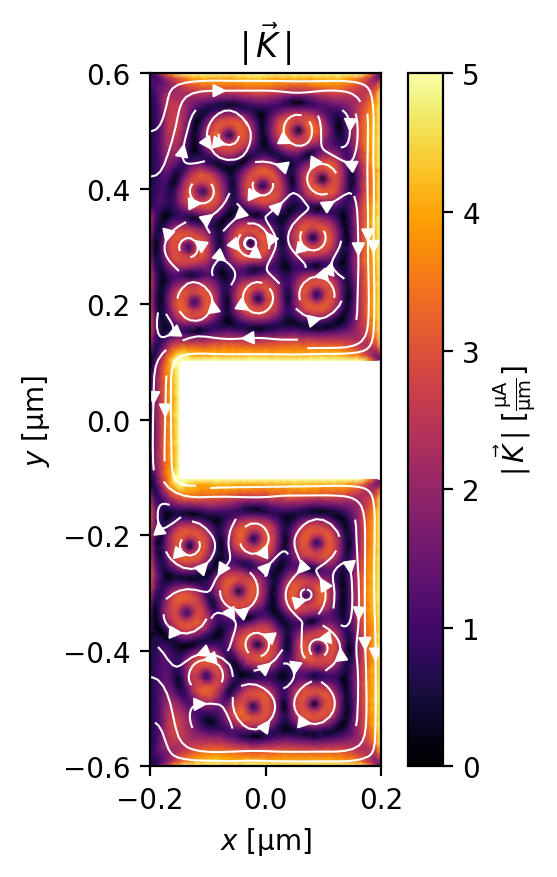

In [174]:
t0 = 100
solution2.solve_step = solution2.closest_solve_step(t0)
fig2, ax2 = solution2.plot_currents(min_stream_amp = 0.05, vmin = 0, vmax = 5, figsize = (3.5, 4.5))
fig2.savefig('K150nA_leftsource.pdf')

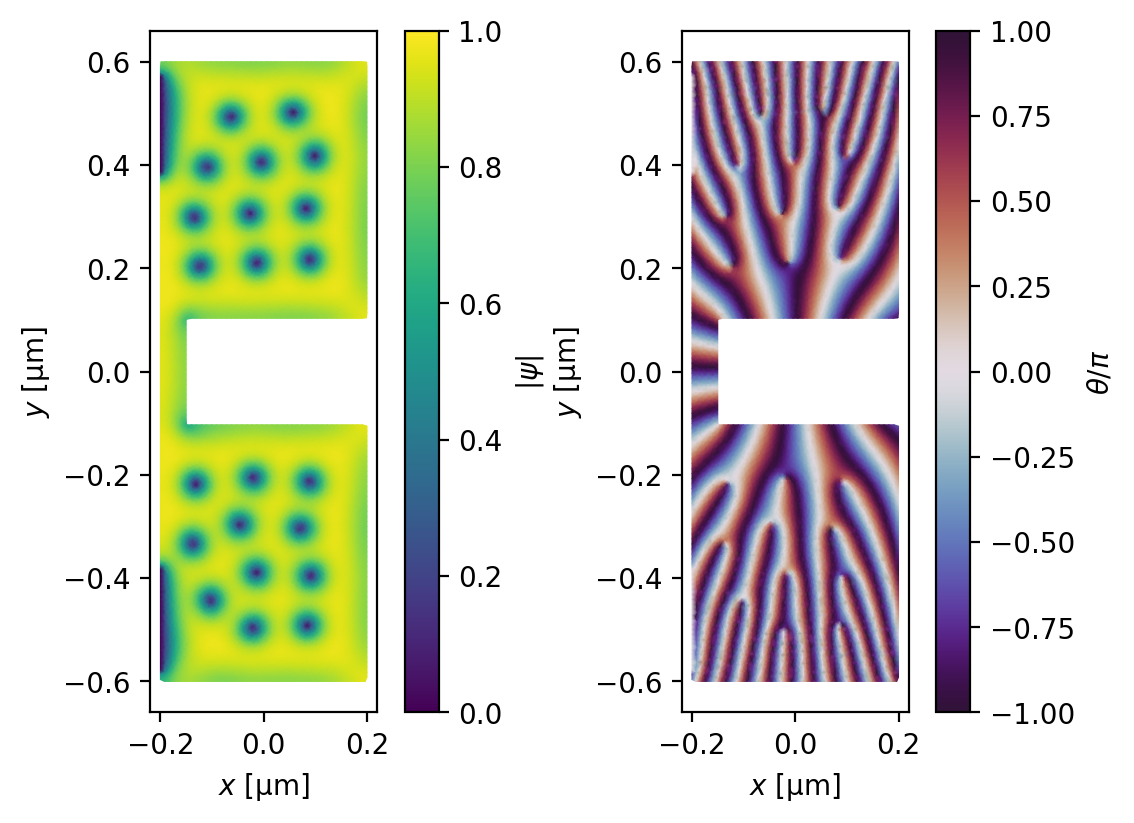

In [170]:
t0 = 100
solution2.solve_step = solution2.closest_solve_step(t0)
fig2, axes2 = solution2.plot_order_parameter(figsize = (5.5, 4))

Text(0, 0.5, '$\\Delta \\phi/ \\pi$')

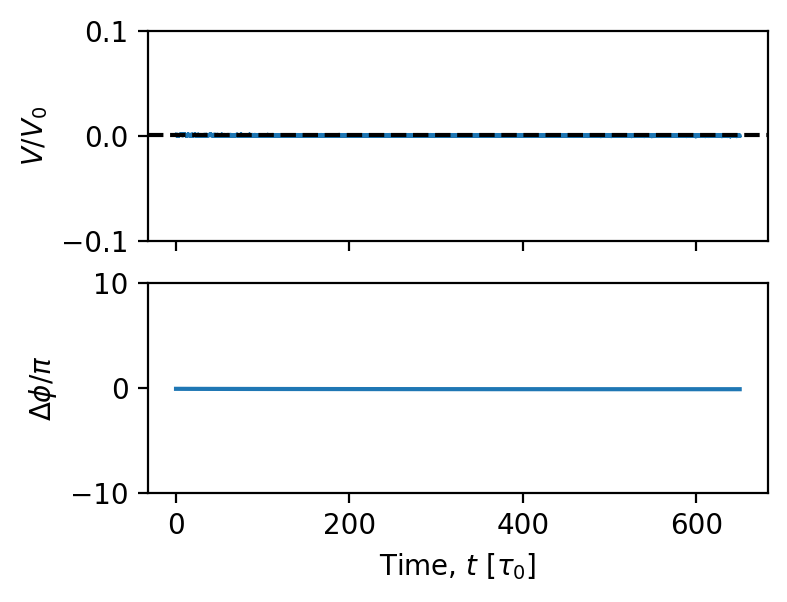

In [171]:
dynamics = solution2.dynamics
fig, axes = dynamics.plot(grid = False, tmax = 800)

fig.set_size_inches((4, 3))
axes[0].set_ylim([-.1, .1])
axes[1].set_ylim([-10, 10])
axes[0].set_ylabel('$V/V_0$')
axes[1].set_ylabel('$\Delta \phi/ \pi$')

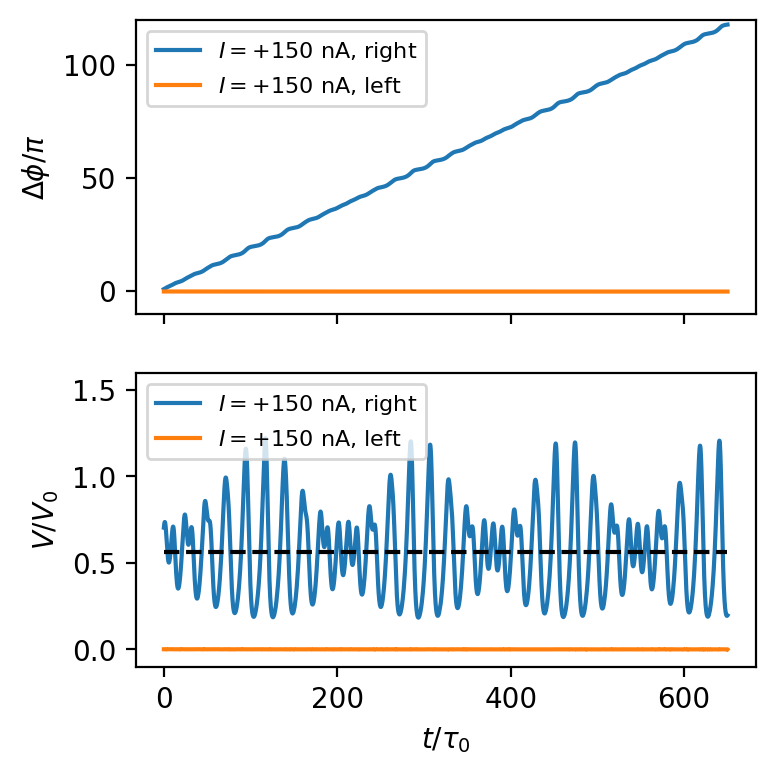

In [183]:
fig, axes = plt.subplots(2, 1, figsize = (4, 4.2))
phases1 = np.unwrap(solution1.dynamics.phase_difference(0, 1)) / np.pi
phases2 = np.unwrap(solution2.dynamics.phase_difference(0, 1)) / np.pi

axes[1].plot(solution1.dynamics.time, solution1.dynamics.voltage())
axes[1].plot(solution2.dynamics.time, solution2.dynamics.voltage())
axes[1].hlines([solution1.dynamics.mean_voltage()], xmin = 0, xmax=650, color='k', linestyle='--')
axes[0].plot(solution1.dynamics.time, -phases1)
axes[0].plot(solution2.dynamics.time, phases2)

axes[0].set_xticklabels([])
axes[1].set_ylim([-0.1, 1.6])
axes[0].set_ylim([-10, 120])
axes[1].set_ylabel('$V/V_0$')
axes[0].set_ylabel('$\Delta \phi/ \pi$')
axes[1].set_xlabel('$t/\\tau_0$')
axes[0].legend(['$I=+150$ nA, right', '$I=+150$ nA, left'], fontsize = 8)
axes[1].legend(['$I=+150$ nA, right', '$I=+150$ nA, left'], fontsize = 8)
# fig.savefig('Vphi_leftright.pdf', bbox_inches='tight')

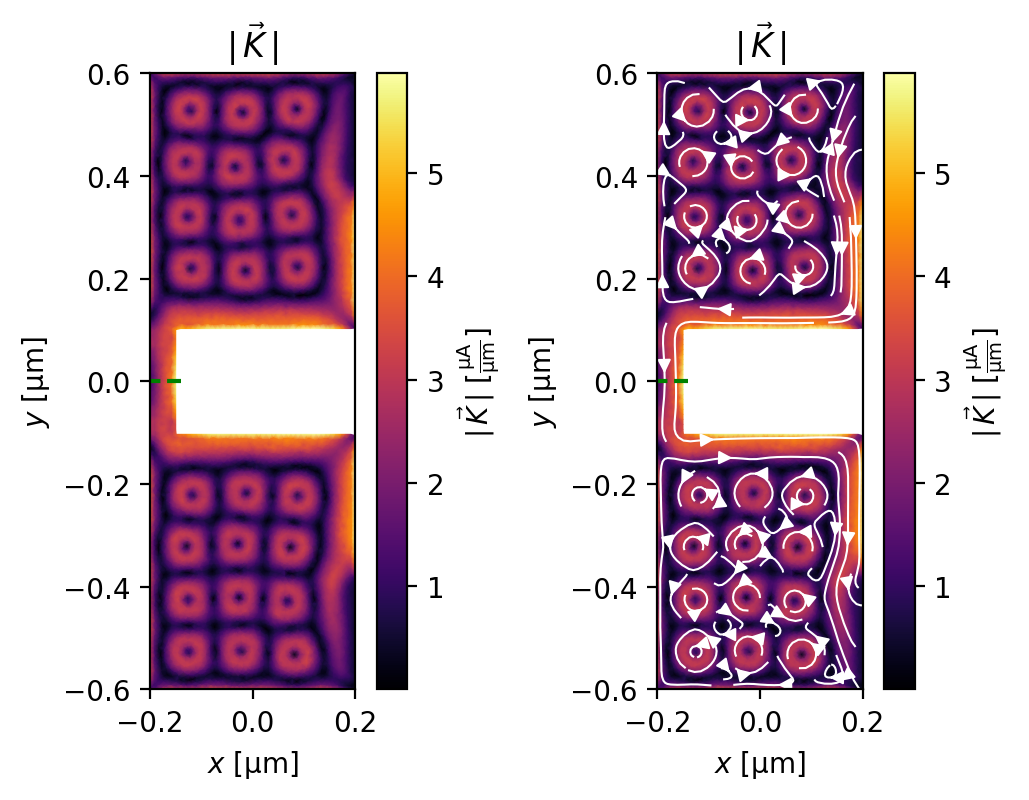

In [199]:
fig, axes = plt.subplots(1, 2, figsize=(6, 4))

_ = solution1.plot_currents(ax=axes[0], streamplot=False)
_ = solution1.plot_currents(ax=axes[1])
x = np.linspace(-total_width / 2 - 0.5 * xi, -total_width / 2 + xi * 3, 401)
y = 2 * np.zeros_like(x)
cross_section = np.array([x, y]).T
for ax in axes:
    _ = ax.plot(x, y, "g--")

In [ ]:
current = solution1.current_through_path(cross_section)
print(f"Measured current: {current:.3f~P}")

Measured current: 0.153 µA


Time steps: 100%|██████████| 823/823 [00:00<00:00, 1383.60it/s]


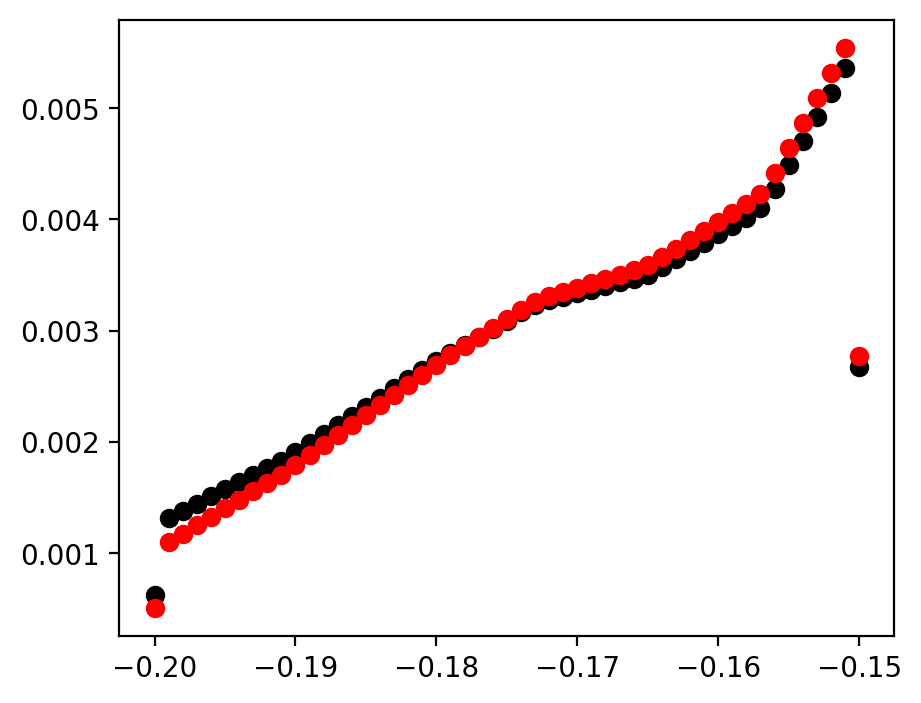

In [278]:
# t0 = 0
# solution1.solve_step = solution1.closest_solve_step(t0)
xn = 50
for x0 in np.linspace(-total_width / 2, -total_width / 2 + xi * 2.5, xn + 1):
    seg = 2.5 * xi / xn
    x = np.linspace(x0 - seg / 2, x0 + seg / 2, 51)
    y = np.zeros_like(x)
    cross_section = np.array([x, y]).T
    # current = solution1.current_through_path(cross_section)
    mean_current = tdgl.get_current_through_paths('/private/var/folders/t7/4qq067ln4xzfz0kchzzzlhkw0000gn/T/tmpvc9fuunl/weak-link-zero-field.h5', cross_section)[1].mean()
    plt.scatter(x0,float(str(mean_current)[0:10]), color = 'k') 

# t0 = 100
# solution2.solve_step = solution2.closest_solve_step(t0)

for x0 in np.linspace(-total_width / 2, -total_width / 2 + xi * 2.5, xn + 1):
    seg = 2.5 * xi / xn
    x = np.linspace(x0 - seg / 2, x0 + seg / 2, 51)
    y = np.zeros_like(x)
    cross_section = np.array([x, y]).T
    # current = solution2.current_through_path(cross_section)
    mean_current = tdgl.get_current_through_paths('/private/var/folders/t7/4qq067ln4xzfz0kchzzzlhkw0000gn/T/tmpvc9fuunl/weak-link-500oe-field-1.h5', cross_section)[1].mean()
    plt.scatter(x0,float(str(mean_current)[0:10]), color = 'r')

In [276]:
a = tdgl.get_current_through_paths('/private/var/folders/t7/4qq067ln4xzfz0kchzzzlhkw0000gn/T/tmpvc9fuunl/weak-link-500oe-field-1.h5', cross_section)[1].mean()

Time steps: 100%|██████████| 823/823 [00:01<00:00, 814.84it/s] 


In [277]:
float(str(a)[0:10])

0.0038618

In [180]:
if MAKE_ANIMATIONS:
    video2 = make_video_from_solution(
        solution2,
        quantities=['order_parameter', 'phase', 'scalar_potential'],
        figsize=(6.5, 4)
    )
    display(video2)

## Change Config, Sweep Current

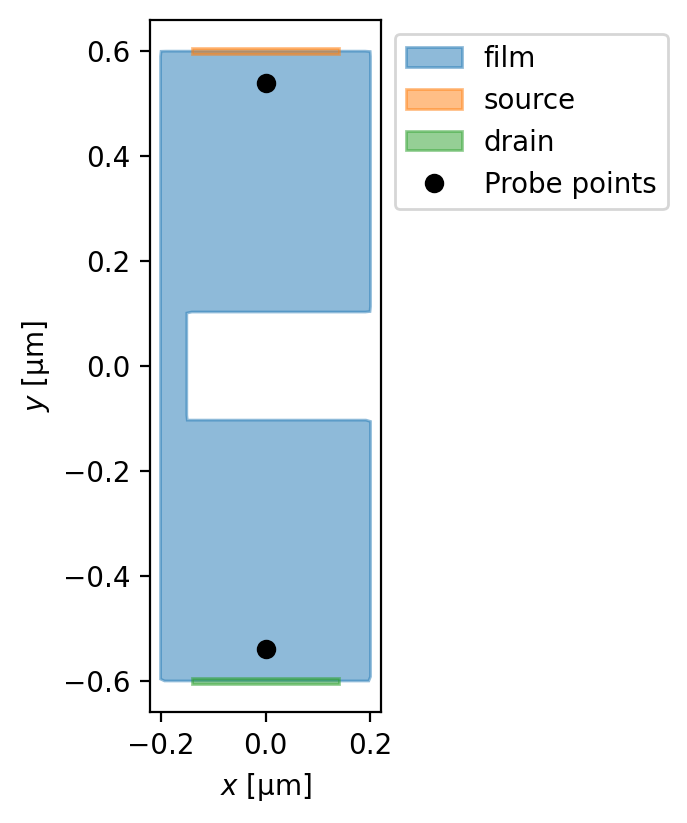

In [280]:
source = (
    tdgl.Polygon("source", points=box(.7 * total_width, total_length / 100))
    .translate(dy=total_length / 2)
)
drain = source.scale(yfact=-1).set_name("drain")

layer1 = tdgl.Layer(coherence_length=xi, london_lambda=london_lambda, thickness=d, gamma=0.0, u=5.79, conductivity=0.3)
device0 = tdgl.Device(
    "rectangle1",
    layer=layer1,
    film=film,
    #holes=[round_hole, square_hole],
    terminals=[source, drain],
    probe_points=probe_points,
    length_units=length_units,
)

fig, ax = device0.draw()

Constructing Voronoi polygons: 100%|██████████| 6039/6039 [00:00<00:00, 22996.14it/s]


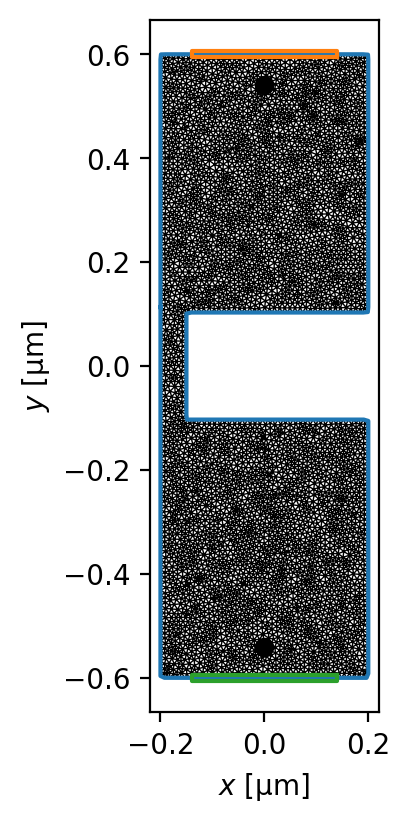

In [281]:
device0.make_mesh(max_edge_length=0.77*xi , smooth=100)
fig, ax = device0.plot(mesh=True, legend=False)
#_ = ax.set_ylim(-7, 7)
device0.mesh_stats()

In [282]:
def getIV(device, current_list, B = 0, ttherm = 80, tsolve = 90, save_every = 1000, filename = 'output.csv'):
    # current_list = np.append(np.linspace(-0.03, -0.21, 121), 0)
    # current_list = np.append(current_list, np.linspace(0.03, 0.21, 121))
    VvsI = pd.DataFrame({'current':current_list})

    voltage_list = np.array([])

    options0 = tdgl.SolverOptions(
        skip_time = ttherm * 2,
        solve_time = tsolve,
        output_file = os.path.join(tempdir.name, f"weak-link-{B}-field.h5"),
        field_units = "mT",
        current_units = "uA",
        save_every = save_every
    )

    seed_solution = solveFluc(
        device,
        options0,
        terminal_currents=dict(source = current_list[0], drain = -current_list[0]),
        applied_vector_potential = B,
        disorder_epsilon = 1,
        T=0.05
    )

    options1 = tdgl.SolverOptions(
        skip_time = ttherm,
        solve_time = tsolve,
        output_file = os.path.join(tempdir.name, f"weak-link-{B}-field.h5"),
        field_units = "mT",
        current_units = "uA",
        save_every = save_every
    )

    for current in current_list:
        if current == 0:
            solution = solveFluc(
                device,
                options0,
                terminal_currents=dict(source = 0, drain = 0),
                applied_vector_potential = B,
                disorder_epsilon = 1,
                T=0.05
            )
        else:
            solution = solveFluc(
                device,
                options1,
                terminal_currents=dict(source = current, drain = -current),
                applied_vector_potential = B,
                disorder_epsilon = 1,
                T=0.05,
                seed_solution = seed_solution
            )
        mean_voltage = solution.dynamics.voltage().mean()
        voltage_list = np.append(voltage_list,  mean_voltage)
        seed_solution = solution

    VvsI['voltage'] = voltage_list
    VvsI.set_index('current', inplace = True)
    VvsI.sort_index(inplace=True, ascending=True)
    VvsI.to_csv(filename)
    return VvsI

In [286]:
current_list = np.append(np.linspace(-0.03, -0.21, 121), 0)
current_list = np.append(current_list, np.linspace(0.03, 0.21, 121))
df_upsource = getIV(device0, current_list, B = 200, ttherm = 180, tsolve = 100, save_every = 1500, filename = 'IV_upsource_new.csv')

Output file already exists. Renaming to /var/folders/t7/4qq067ln4xzfz0kchzzzlhkw0000gn/T/tmpvc9fuunl/weak-link-200-field-2.h5.
Simulating: 100%|█████████▉| 100/100 [00:13<00:00,  7.21tau/s ]
Output file already exists. Renaming to /var/folders/t7/4qq067ln4xzfz0kchzzzlhkw0000gn/T/tmpvc9fuunl/weak-link-200-field-3.h5.
Simulating: 100%|█████████▉| 100/100 [00:13<00:00,  7.23tau/s ]
Output file already exists. Renaming to /var/folders/t7/4qq067ln4xzfz0kchzzzlhkw0000gn/T/tmpvc9fuunl/weak-link-200-field-4.h5.
Simulating: 100%|█████████▉| 100/100 [00:13<00:00,  7.36tau/s ]
Output file already exists. Renaming to /var/folders/t7/4qq067ln4xzfz0kchzzzlhkw0000gn/T/tmpvc9fuunl/weak-link-200-field-5.h5.
Simulating: 100%|█████████▉| 100/100 [00:13<00:00,  7.42tau/s ]
Output file already exists. Renaming to /var/folders/t7/4qq067ln4xzfz0kchzzzlhkw0000gn/T/tmpvc9fuunl/weak-link-200-field-6.h5.
Simulating: 100%|█████████▉| 100/100 [00:13<00:00,  7.37tau/s ]
Output file already exists. Renaming to /var/

In [287]:
df_rightsource = getIV(device1, current_list, B = 200, ttherm = 180, tsolve = 100, save_every = 1500, filename = 'IV_rightsource_new.csv')

Output file already exists. Renaming to /var/folders/t7/4qq067ln4xzfz0kchzzzlhkw0000gn/T/tmpvc9fuunl/weak-link-200-field-246.h5.
Simulating: 100%|█████████▉| 100/100 [00:13<00:00,  7.67tau/s ]
Output file already exists. Renaming to /var/folders/t7/4qq067ln4xzfz0kchzzzlhkw0000gn/T/tmpvc9fuunl/weak-link-200-field-247.h5.
Simulating: 100%|█████████▉| 100/100 [00:13<00:00,  7.33tau/s ]
Output file already exists. Renaming to /var/folders/t7/4qq067ln4xzfz0kchzzzlhkw0000gn/T/tmpvc9fuunl/weak-link-200-field-248.h5.
Simulating: 100%|█████████▉| 100/100 [00:13<00:00,  7.55tau/s ]
Output file already exists. Renaming to /var/folders/t7/4qq067ln4xzfz0kchzzzlhkw0000gn/T/tmpvc9fuunl/weak-link-200-field-249.h5.
Simulating: 100%|█████████▉| 100/100 [00:13<00:00,  7.62tau/s ]
Output file already exists. Renaming to /var/folders/t7/4qq067ln4xzfz0kchzzzlhkw0000gn/T/tmpvc9fuunl/weak-link-200-field-250.h5.
Simulating: 100%|█████████▉| 100/100 [00:13<00:00,  7.64tau/s ]
Output file already exists. Renamin

In [288]:
df_leftsource = getIV(device2, current_list, B = 200, ttherm = 180, tsolve = 100, save_every = 1500, filename = 'IV_leftsource_new.csv')

Output file already exists. Renaming to /var/folders/t7/4qq067ln4xzfz0kchzzzlhkw0000gn/T/tmpvc9fuunl/weak-link-200-field-490.h5.
Simulating: 100%|█████████▉| 100/100 [00:13<00:00,  7.51tau/s ]
Output file already exists. Renaming to /var/folders/t7/4qq067ln4xzfz0kchzzzlhkw0000gn/T/tmpvc9fuunl/weak-link-200-field-491.h5.
Simulating: 100%|█████████▉| 100/100 [00:13<00:00,  7.61tau/s ]
Output file already exists. Renaming to /var/folders/t7/4qq067ln4xzfz0kchzzzlhkw0000gn/T/tmpvc9fuunl/weak-link-200-field-492.h5.
Simulating: 100%|█████████▉| 100/100 [00:13<00:00,  7.63tau/s ]
Output file already exists. Renaming to /var/folders/t7/4qq067ln4xzfz0kchzzzlhkw0000gn/T/tmpvc9fuunl/weak-link-200-field-493.h5.
Simulating: 100%|█████████▉| 100/100 [00:13<00:00,  7.65tau/s ]
Output file already exists. Renaming to /var/folders/t7/4qq067ln4xzfz0kchzzzlhkw0000gn/T/tmpvc9fuunl/weak-link-200-field-494.h5.
Simulating: 100%|█████████▉| 100/100 [00:13<00:00,  7.64tau/s ]
Output file already exists. Renamin

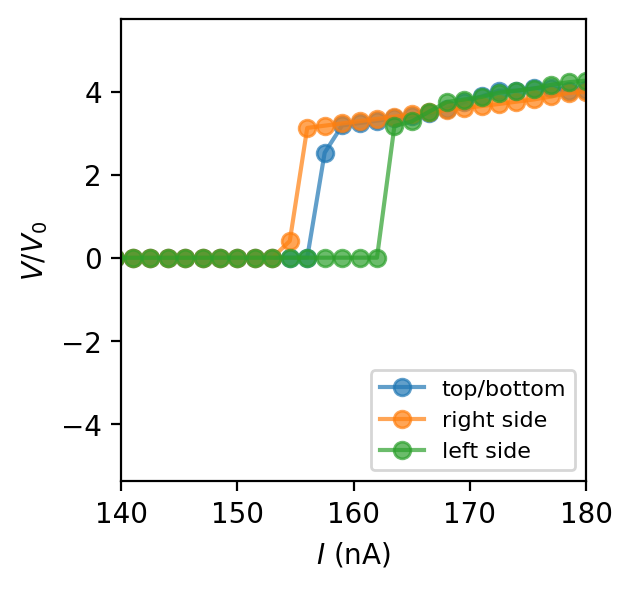

In [312]:
fig, ax = plt.subplots(1, 1, figsize = (3, 3))
# IVdesktop = pd.read_csv('left-weak-link-VvsIvsB-all.csv')

ax.plot(df_upsource.index * 1e3, df_upsource.voltage, 'o-', alpha=0.7, label = 'top/bottom')
# ax.plot(IVdesktop.current, IVdesktop['200'], 's-')
ax.plot(df_rightsource.index * 1e3, df_rightsource.voltage, 'o-', alpha=0.7, label = 'right side')
ax.plot(df_leftsource.index * 1e3, df_leftsource.voltage, 'o-', alpha=0.7, label = 'left side')

ax.legend(fontsize=8, loc = 'lower right')
ax.set_xlim(140, 180)

ax.set_xlabel('$I$ (nA)')
ax.set_ylabel('$V/V_0$')
fig.savefig('IV_changeconfig_positive.pdf', bbox_inches='tight')

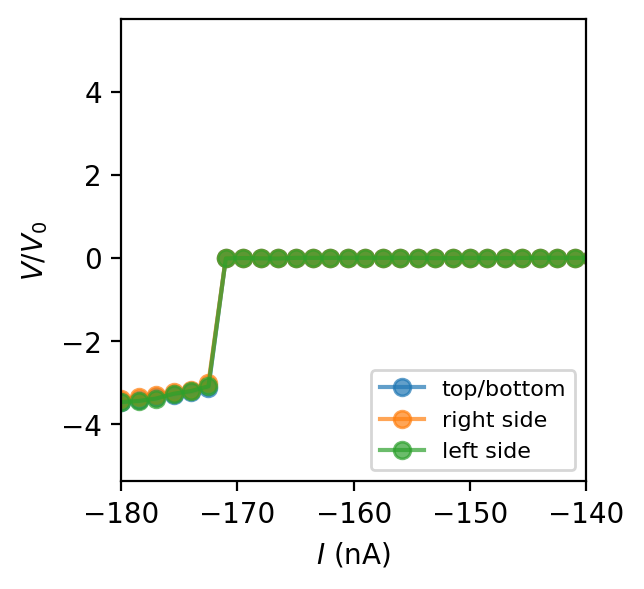

In [313]:
fig, ax = plt.subplots(1, 1, figsize = (3, 3))
# IVdesktop = pd.read_csv('left-weak-link-VvsIvsB-all.csv')
# df_leftsource = pd.read_csv('IV_leftsource_new.csv', index_col=0)
# df_rightsource = pd.read_csv('IV_rightsource_new.csv', index_col=0)
# df_upsource = pd.read_csv('IV_upsource_new.csv', index_col=0)

ax.plot(df_upsource.index * 1e3, df_upsource.voltage, 'o-', alpha=0.7, label = 'top/bottom')
# ax.plot(IVdesktop.current, IVdesktop['200'], 's-')
ax.plot(df_rightsource.index * 1e3, df_rightsource.voltage, 'o-', alpha=0.7, label = 'right side')
ax.plot(df_leftsource.index * 1e3, df_leftsource.voltage, 'o-', alpha=0.7, label = 'left side')

ax.legend(fontsize=8, loc = 'lower right')
ax.set_xlim(-180, -140)

ax.set_xlabel('$I$ (nA)')
ax.set_ylabel('$V/V_0$')
fig.savefig('IV_changeconfig_negative.pdf', bbox_inches='tight')